# KL Divergence

**TLDR**
* Kullback-Leibler (KL) Divergence is a common metric used when working with distributions
  * It measures the _non-symmetric_ "distance" between two distributions
* KL Divergence is used commonly in RL to measure how "far" policies have updated
  * Different RL algorithms use forward, backward, or Jeffrey's divergence in their calculations
* Calculating KL Divergence exactly can be expensive so approximations are often used

## KL Divergence Primer
RL Implementations commonly include KL Divergence in both their mathematical formulas and their code implementation.
At its core, it's a simple concept, but tracing its implementation in practice can be a confusing mess of approximations paired with computational stability tricks. This makes it hard to understand how the high-level concept maps to the specific code implementation or paper you're studying. And unfortunately, a faulty implementation of KL Divergence can break our entire training objective. So, before starting a big training run, ensuring it's correct ahead of time will save you many headaches.

Let's talk through practical KL divergence in the LLM context with three levels
* **Level 1**: A basic working intuition of the concept
* **Level 2**: A deeper explanation of the common approximators you'll see
* **Level 3**: A full explanation with code of why approximations are needed, and then a deep explanation of forward and reverse KL

```{admonition} Still under review
The information in here should be correct, but I'm having a couple of my colleagues check it over just to be sure.
If you notice anything wrong open up an issue ticket, contributions are welcome.
```

## Level 1: Intuition
KL Divergence measures the "difference" between two distributions.
This is useful because in Reinforcement Learning, we want to compare versions of model outputs with each other during training.

### Divergence not distance
We don't use the word 'distance' for a reason; even putting 'difference' in quotes.
This is because KL Divergence is not symmetric.
More on this later.

In [1]:
import torch
import torch.distributions as dis
import matplotlib.pyplot as plt
import numpy as np

In [2]:
p = dis.Normal(loc=0, scale=1)
q_1 = dis.Normal(loc=1, scale=1)
q_2 = dis.Normal(loc=5, scale=1)
q_3 = dis.Normal(loc=0, scale=2)

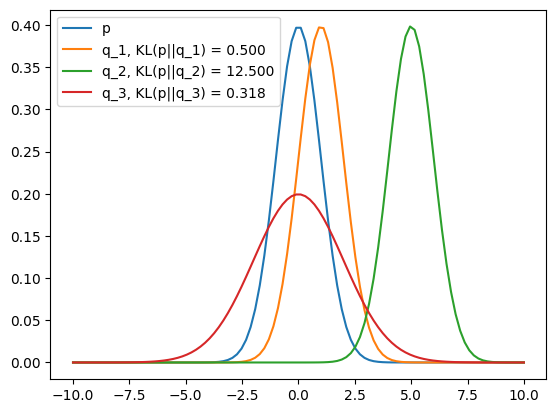

In [3]:
kl_1 = dis.kl_divergence(p, q_1)
kl_2 = dis.kl_divergence(p, q_2)
kl_3 = dis.kl_divergence(p, q_3)

x = torch.linspace(-10, 10, 100)

fig, ax = plt.subplots()
ax.plot(x, torch.exp(p.log_prob(x)), label='p')
ax.plot(x, torch.exp(q_1.log_prob(x)), label=f'q_1, KL(p||q_1) = {kl_1:.3f}')
ax.plot(x, torch.exp(q_2.log_prob(x)), label=f'q_2, KL(p||q_2) = {kl_2:.3f}')
ax.plot(x, torch.exp(q_3.log_prob(x)), label=f'q_3, KL(p||q_3) = {kl_3:.3f}')

ax.legend();

We can use KL Divergence to make sure our policy updates are not too big,
which is why you see it as a penalty term for weight updates.

In Reinforcement Learning literature, p and q are often denoted by

In [4]:
# Reference Policy
π_ref = dis.Normal(loc=0, scale=1)

# Training Policy
π_θ = dis.Normal(loc=5, scale=1)
kl_1 = dis.kl_divergence(π_θ, π_ref)
x = torch.linspace(-10, 10, 100)

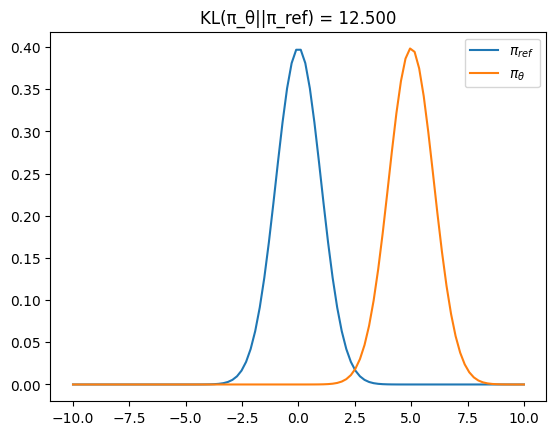

In [5]:
fig, ax = plt.subplots()
ax.plot(x, torch.exp(π_ref.log_prob(x)), label='$π_{ref}$')
ax.plot(x, torch.exp(π_θ.log_prob(x)), label='$π_θ$')
ax.set_title(f'KL(π_θ||π_ref) = {kl_1:.3f}')
ax.legend();

## Level 2: KL Divergence Approximation

KL Divergence is not always simple to calculate.
From [John Schulman's blog](http://joschu.net/blog/kl-approx.html)

1. Computing it exactly requires too much computation or memory.
2. There’s no closed form expression.
3. We can simplify code by just storing the log-prob, not the whole distribution. This is a reasonable choice if KL is just being used as a diagnostic, as is often the case in reinforcement learning.

John then goes on to derive these three estimators,
and shows that the third estimator is the best because it has no bias and a lower variance than the other estimators.

In [6]:
p = dis.Normal(loc=0, scale=1)
q = dis.Normal(loc=0.1, scale=1)
x = q.sample(sample_shape=(10_000_000,))

truekl = dis.kl_divergence(p, q)
print("true", truekl)


logr = p.log_prob(x) - q.log_prob(x)
k1 = -logr # Approximation 1
k2 = logr ** 2 / 2 # Approximation 2
k3 = (logr.exp() - 1) - logr # Approximation 3

for k in (k1, k2, k3):
    print((k.mean() - truekl) / truekl, k.std() / truekl)

true tensor(0.0050)
tensor(-0.0074) tensor(20.0014)
tensor(0.0026) tensor(1.4189)
tensor(0.0001) tensor(1.4177)


### Why Approximations are Fine

Approximations are okay because KL Divergence is just a regularizer in our loss term, so exact divergence is not needed.
Additionally, because it's weighted (often with $\beta$) and clipped in many implementations, it matters even less that it's exact.
It just needs to be relatively unbiased.

For a good explanation of the Deepseek implementation of KL, which uses k3 as noted above, watch this video from Yacine. https://www.youtube.com/watch?v=iHf6mMiiNOw

## Level 3: All the details
This section details an LLM-specific scenario where we are sampling over multi-step categorical distributions.

With LLMs we have two axes of complexity
1. Large vocab/action size $V$ - Often 64,000 or higher
2. Long generation sequences $T$ - With reasoning traces 5000 token sequences or more

If a method requires calculating or storing these $V \times V$ conditional probability matrices,
its complexity becomes exponential in the sequence length, $O(V^T)$.
This will take both huge amounts of memory and computational calculation.

To illustrate let's go through an exact calculation with a restricted example,
before then going through two approximations.

### Setup
Consider a token space of 5, where each word is a token.
Additionally we'll artificially construct a two-step generation.

In [7]:
# Token space order: ['Ravin', 'likes', 'salad', 'apples', 'pizza']
TOKEN_SPACE = np.array(['Ravin', 'likes', 'salad', 'apples', 'pizza'])
TOKEN_INDICES = {token: i for i, token in enumerate(TOKEN_SPACE)}

prompt = "Ravin"
completion = "likes salad"

In this example
* Step 1 is likes
* Step 2 is salad

For the first step, because we only have one preceding token, our probability space has a shape of (5,), with one probability for each token that could possibly be generated.

We'll also define the probabilities for both policy $π_{ref}$ and a trained policy $π_θ$.
We need both because these are the policies/probability distributions that we want to measure the divergence from.

In [8]:
# Reference (Old) Policy Probabilities (Q distribution) for Step 1: P(x1)
step_1_ref = np.array([0.05, 0.60, 0.10, 0.15, 0.10]) 

# Policy (New) Policy Probabilities (P distribution) for Step 1: P(x1)
step_1_pol = np.array([0.05, 0.78, 0.01, 0.15, 0.01]) 

For the second step, however, our probability is conditional because it depends on what token is selected in the step prior which is why our joint probability space is $5x5$.
If we were to include a third step the shape would be $5x5x5$,
from this you can already get a sense of just the memory needs for full KL divergence calculation.

In [9]:
# --- 2. Conditional Probability Matrices (The Fix!) ---
# Rows = Previous Token (x1), Columns = Current Token (x2)
# The row index corresponds to TOKEN_INDICES.
# Q_matrix[i, j] is P_ref(x2=j | x1=i)

# Reference Conditional Matrix (Q)
# New Q_matrix: If 'likes' (index 1) was chosen, 'salad' (index 2) is now much more likely.
step_2_ref_matrix = np.array([
    [0.11, 0.14, 0.30, 0.20, 0.25], # If x1='Ravin' (index 0)
    [0.01, 0.01, 0.80, 0.10, 0.08], # If x1='likes' (index 1) <- New dependence: high 'salad' prob
    [0.10, 0.10, 0.10, 0.30, 0.40], # If x1='salad' (index 2)
    [0.10, 0.10, 0.20, 0.50, 0.10], # If x1='apples' (index 3)
    [0.20, 0.20, 0.20, 0.20, 0.20]  # If x1='pizza' (index 4)
])

# Policy Conditional Matrix (P)
# New P_matrix: If 'likes' (index 1) was chosen, 'salad' (index 2) is nearly certain.
step_2_pol_matrix = np.array([
    [0.01, 0.04, 0.80, 0.10, 0.05], # If x1='Ravin' (index 0)
    [0.00, 0.00, 0.95, 0.05, 0.00], # If x1='likes' (index 1) <- New dependence: very high 'salad' prob
    [0.05, 0.05, 0.50, 0.20, 0.20], # If x1='salad' (index 2)
    [0.00, 0.00, 0.20, 0.80, 0.00], # If x1='apples' (index 3)
    [0.05, 0.05, 0.05, 0.05, 0.80]  # If x1='pizza' (index 4)
])

### Exact Calculation
Now that we have our first step and second step probability tensors we can calculate KL Divergence.
The formula for KL divergence is usually stated as such

$$
D_{\text{KL}}(P \parallel Q) = \sum_{x \in \mathcal{X}} P(x) \log \frac{P(x)}{Q(x)}
$$

This formula is a bit misleading at a glance because it can be misunderstood that x is of shape $(1,X)$. As alluded above though in LLM cases what's actually needed is the *joint probability over the entire generated token sequence*. 
Here is the same equation as above, 
but in notation that makes the combinatorial complexity much more obvious.

$$
D_{KL}(P_{\text{joint}} || Q_{\text{joint}}) = \sum_{x_1} \cdots \sum_{x_T} P(x_1, \dots, x_T) \log \left( \frac{P(x_1, \dots, x_T)}{Q(x_1, \dots, x_T)} \right)
$$

With our sample token sequence we can calculate the exact KL divergence for reference.

In [10]:
# Exact Joint KL Divergence Calculation
# D_KL(P_joint || Q_joint) where P_joint(x1, x2) = P(x1) * P(x2 | x1)

# P_joint(i, j) = P(x1=i) * P(x2=j | x1=i)
P_joint = step_1_pol[:, np.newaxis] * step_2_pol_matrix

# Q_joint(i, j) = Q(x1=i) * Q(x2=j | x1=i)
Q_joint = step_1_ref[:, np.newaxis] * step_2_ref_matrix

P_flat = P_joint.flatten()
Q_flat = Q_joint.flatten()
print(Q_flat.shape)
# # Suppress warnings for division by zero or log(0)
# np.seterr(divide='ignore', invalid='ignore')

# Identify terms where P is greater than zero
valid_indices = P_flat > 1e-12 
P_valid = P_flat[valid_indices]
Q_valid = Q_flat[valid_indices]

# Calculate the exact KL Divergence: sum(P * log(P/Q))
log_ratio = np.log(P_valid / Q_valid)
kl_divergence_exact = np.sum(P_valid * log_ratio)
kl_divergence_exact

(25,)


np.float64(0.3568151101092548)

### Linear Approximation: Drop the Conditional
The first approximation we can make is to drop the conditional dependence.
We just calculate the KL at each token generation step and ignore the branching paths.

In [21]:
def calculate_single_step_kl(p_dist, q_dist):
    valid_p = p_dist > 1e-12 # Filter out zero probability indicies to avoid issues
    p_valid = p_dist[valid_p]
    q_valid = q_dist[valid_p]
    return np.sum(p_valid * np.log(p_valid / q_valid))

# Step 1: KL divergence over the distribution for the first token "likes".
kl_divergence_step1 = calculate_single_step_kl(step_1_pol, step_1_ref)

# Step 2: For the linear approximation, we calculate the KL divergence
# of the *entire distribution* for the second token. This requires conditioning
# on the first token from our sequence ("likes" -> "salad").
# The conditioning (previous) token is 'likes', which has an index of 1.
prev_token_index = 1 # Index for 'likes', the conditioning token
P_x2_cond = step_2_pol_matrix[prev_token_index]
Q_x2_cond = step_2_ref_matrix[prev_token_index]
kl_divergence_step2 = calculate_single_step_kl(P_x2_cond, Q_x2_cond)


kl_divergence_linear_approx = kl_divergence_step1 + kl_divergence_step2
kl_divergence_linear_approx

np.float64(0.2871928094770909)

For multiple steps we can take the mean over token steps as well,
just as in the calculations above from John Schulman's example.

In [12]:
kl_divergence_linear_approx = (kl_divergence_step1 + kl_divergence_step2)/2

### KL Divergence Approximated just from Sampled Token sequence
The example above reduces the exponential joint probability calculations to a $O(V)$ linear complexity,
However, we still may not want to store the entire token probability matrices (V, T) for a vocabulary of size V and a sequence of length T, because this still takes up memory,
especially if we also include batch dimensions.

We can simplify further by approximating KL just from probabilities of the sampled tokens.
The code below looks more complex, 
however in practice this code is already needed as part of the sampler,
and we are just storing the bare minimum number of floats.

In [13]:
def calculate_trajectory_kl_penalty(sequence, pol_dist_1, pol_matrix_2, ref_dist_1, ref_matrix_2):
    """
    Calculates the PPO-style KL Penalty: Sum of log(P_pol / P_ref) along the sequence.
    Now correctly handles P(x2 | x1).
    """
    if len(sequence) != 2:
        raise ValueError("Sequence length must be 2 for this example.")
    
    print("\n--- KL PENALTY CALCULATION FOR TRAJECTORY: Ravin -> likes -> salad ---")
    
    # Step 1: P(x1)
    x1_token = sequence[0]
    x1_index = TOKEN_INDICES[x1_token]
    P_x1 = pol_dist_1[x1_index]
    Q_x1 = ref_dist_1[x1_index]
    
    log_ratio_1 = np.log(P_x1 / Q_x1)

    print(f"Step 1 ('{x1_token}'):")
    print(f"  P_pol({x1_token}) = {P_x1:.2f}, P_ref({x1_token}) = {Q_x1:.2f}")
    print(f"  Log-Ratio: ln({P_x1:.2f} / {Q_x1:.2f}) = {log_ratio_1:.6f}")

    # Step 2: P(x2 | x1)
    x2_token = sequence[1]
    x2_index = TOKEN_INDICES[x2_token]
    
    # x1_index is the row (condition), x2_index is the column (outcome)
    P_x2_cond_x1 = pol_matrix_2[x1_index, x2_index]
    Q_x2_cond_x1 = ref_matrix_2[x1_index, x2_index]


    log_ratio_2 = np.log(P_x2_cond_x1 / Q_x2_cond_x1)
    total_kl_penalty = log_ratio_1 + log_ratio_2
    
    print(f"Step 2 ('{x2_token}' | '{x1_token}'):")
    print(f"  P_pol({x2_token}|{x1_token}) = {P_x2_cond_x1:.2f}, P_ref({x2_token}|{x1_token}) = {Q_x2_cond_x1:.2f}")
    print(f"  Log-Ratio: ln({P_x2_cond_x1:.2f} / {Q_x2_cond_x1:.2f}) = {log_ratio_2:.6f}")
    
    print("-------------------------------------------------------------------")
    print(f"Total KL Penalty (Sum of Log-Ratios): {total_kl_penalty:.6f} nats")
    return total_kl_penalty


# Define the sequence and distributions for the trajectory calculation
trajectory = ["likes", "salad"]
# The function now takes the 1D and 2D arrays directly
kl_penalty_trajectory = calculate_trajectory_kl_penalty(
    trajectory, step_1_pol, step_2_pol_matrix, step_1_ref, step_2_ref_matrix
)


--- KL PENALTY CALCULATION FOR TRAJECTORY: Ravin -> likes -> salad ---
Step 1 ('likes'):
  P_pol(likes) = 0.78, P_ref(likes) = 0.60
  Log-Ratio: ln(0.78 / 0.60) = 0.262364
Step 2 ('salad' | 'likes'):
  P_pol(salad|likes) = 0.95, P_ref(salad|likes) = 0.80
  Log-Ratio: ln(0.95 / 0.80) = 0.171850
-------------------------------------------------------------------
Total KL Penalty (Sum of Log-Ratios): 0.434215 nats


## Forward/Mode Seeking vs Reverse/Mode Covering
In RL, but also other algorithms such as Variational Inference in Bayes, we use KL Divergence as part of the optimization target.
We have a "true" distribution that we are trying to approximate with the distribution our model is estimating.
As mentioned before KL divergence helps us measure how "far" our estimated distribution is
However an important property of KL Divergence is that it's **not** symmetric.
$$D_{\text{KL}}(P \parallel Q) \neq D_{\text{KL}}(Q \parallel P)$$

Reversing the terms here actually has such a big effect that there are two names depending on the order of the terms and whether we are minimizing or maximizing.
To understand in the context of LLM RL, let's replace the $P$ and $Q$ with $\pi_{\theta}$ and $\pi_{\text{ref}}$.
In RL, typically 
* $\pi_{\theta}$ - The weights that we are actively optimizing
* $\pi_{\text{ref}}$ - The weights (or policy) that are fixed, also sometimes called the anchor

We can also rewrite our equation above as

$$D_{\text{KL}}(\pi_{\theta} \parallel \pi_{\text{ref}}) \neq D_{\text{KL}}(\pi_{\text{ref}} \parallel \pi_{\theta})$$

Now one of these sides is forward KL and the other is reverse KL.
The choice of which one you use will affect the behavior of your final LLMs.
In LLMs and RL, the general intuition is
* Forward/Inclusive/Mode Covering RL will keep diversity covering all the modes. For example, in the health example, it'll keep Ravin's behavior of picking a variety of foods.
* Reverse/exclusive/Mode Seeking RL will collapse diversity, pushing the distribution to "pick" one of the modes.

Which one is which, though, depends on both the order of the terms, 
and also whether we are minimizing or maximizing the KL component of our loss,
which also depends on whether we are adding or subtracting the KL term in our policy optimization target.

To make matters even more complicated, there's also a concept called Jeffreys' Divergence, which is a combination of both of these.

$$
Jeffreys' Divergence = D_{\text{KL}}(\pi_{\theta} \parallel \pi_{\text{ref}}) + D_{\text{KL}}(\pi_{\text{ref}} \parallel \pi_{\theta})
$$

### Verifying Which One You're Working With
This can all get confusing so the easiest way to check is just re-implement a minimal examples in code,
and verify every detail is exactly correct.
That is
* The order of the terms in the KL approximator
* Minimization or maximization by your optimizer
* The sign of your KL component

Here is an example where we implement the KL objective from the Deepseek Math GRPO paper,
where they **maximize a negative reverse KL**.
We first create a bimodal reference distribution.
We need a bimodal reference so we can tell later whether the optimization is mode-covering or mode-seeking.

In [14]:
# Create a bimodal reference distribution
x = torch.linspace(-10, 10, 1000)
π_ref_1 = dis.Normal(loc=-3, scale=1)
π_ref_2 = dis.Normal(loc=3, scale=1)

# Bimodal mixture (50-50)
log_π_ref = torch.logsumexp(torch.stack([
    π_ref_1.log_prob(x) + torch.tensor(.2),
    π_ref_2.log_prob(x) + torch.tensor(.9)
]), dim=0)

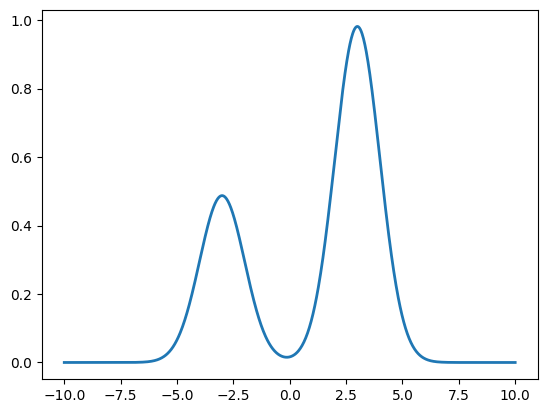

In [15]:
fig, ax = plt.subplots()
ax.plot(x, log_π_ref.exp(), label='π_ref (bimodal)', linewidth=2);

We can then implement a basic optimizer that fits a normal distribution's mean and scale per our optimization target.

In [16]:
# Initialize policy distribution
loc = torch.tensor(-3., requires_grad=True)
scale = torch.tensor(1., requires_grad=True)

# Maximization target to match DRPO objective
optimizer = torch.optim.Adam([loc, scale], lr=0.05, maximize=True)

# Optimize for 1000 steps
losses = []
for step in range(1000):
    optimizer.zero_grad()
    
    π_θ = dis.Normal(loc=loc, scale=scale.abs() + 1e-6)
    log_π_θ = π_θ.log_prob(x)
    
    # K3 approximation for reverse KL
    logr = log_π_θ - log_π_ref   # Mode Covering. This is what is in the GRPO paper
    # logr = log_π_ref - log_π_θ  # Mode Seeking. This is the opposite. Uncomment and see the difference.

    k3 = (logr.exp() - 1) - logr

    # In GRPO paper we want to maximize -kl, so minimize +kl
    loss = -k3.mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

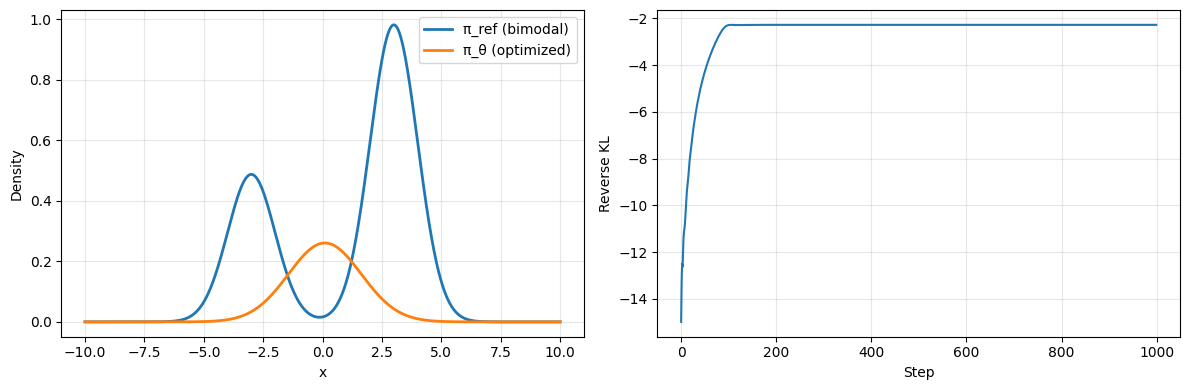

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distributions
axes[0].plot(x.detach(), log_π_ref.exp().detach(), label='π_ref (bimodal)', linewidth=2)
axes[0].plot(x.detach(), π_θ.log_prob(x).exp().detach(), label='π_θ (optimized)', linewidth=2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Training loss
axes[1].plot(losses)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Reverse KL')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show();

## Other Implementations
I again want to stress that the choice of forward, backward, or Jeffreys' Divergence is a choice. 
In the [BOND paper](https://arxiv.org/pdf/2407.14622) the authors choose to use Jeffrey's Divergence to balance between mode seeking and mode covering.
They write

> The choice of the divergence metric used in BOND is of crucial importance: different divergences
can steer the policy to very different solutions. Here, we propose the Jeffreys divergence as a robust
distribution matching objective.
The Jeffreys divergence (Jeffreys, 1946) between two distributions is defined as:
>
> $$J^{\beta}_{\text{effreys}}(p \| q) := (1 - \beta) \cdot \underbrace{\text{KL}(q \| p)}_{\text{Forward KL}} + \beta \cdot \underbrace{\text{KL}(p \| q)}_{\text{Backward KL}}.$$
>
> The (generalized) Jeffreys divergence is a weighted average (with weight 𝛽 ∈ [0, 1]) between the
forward and backward KL divergence. Notably, when fine-tuning policy 𝑝, the forward KL(𝑞 ∥ 𝑝)
encourages that generations likely under 𝑞 are also likely under 𝑝, thus encouraging a mode-covering
behavior. Instead, the reverse KL( 𝑝 ∥ 𝑞) is well-known to have a mode-seeking effect, steering policy
𝑝 to produce generations that have a high likelihood according to 𝑞 (Agarwal et al., 2024). While
the forward KL may produce over-spread distributions, the backward KL can lead to policy and
entropy collapses. Instead, we empirically show that the Jeffreys divergence inherits the best of both
divergences, producing better aligned policies.

## Suggested Prompts
* Where is KL Divergence used outside of its application with LLMs? What about with LLMs?
* When would we prefer forward, backward, and symmetric KL?
* What are the challenges with calculating KL Divergence?

## References
* [Approximating KL Divergence](http://joschu.net/blog/kl-approx.html) - John Schulman's blogpost which is now the canonical reference for KL Divergence approximations.
* [Reverse vs Forward KL](https://www.tuananhle.co.uk/notes/reverse-forward-kl.html) - An in depth explanation of reverse vs forward KL and how each differ.
* [Video Explanation of Reverse vs Forward](https://youtu.be/tXE23653JrU?t=308) - An animated explanation for folks that prefer visual learning.
* [BOND Paper](https://arxiv.org/pdf/2407.14622) - An RL paper for LLM alignment that goes into detail as to why a particular KL choice of Jeffrey's divergence was made.
* [KL Divergence in Deepseek R1](https://www.youtube.com/watch?v=iHf6mMiiNOw) - An in depth explanation of KL Divergence in DeepSeek GRPO.